In [1]:
import sys
AUX_PATH = '/home/nata/Projects/Active/src'
if AUX_PATH not in sys.path:
    sys.path.insert(0, AUX_PATH)
import utils
import preprocessing
import models
import tournament

import pandas as pd
import numpy as np
import xgboost as xgb
import warnings
import matplotlib.pyplot as plt
import datetime as dt

from joblib import Parallel, delayed
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import TimeSeriesSplit

warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [9]:
df = pd.read_csv('../data/raw/sellout/SO.csv', sep=';', encoding='windows-1251', dtype={'Sku/линейка':'str'})
df.head()

DATE         TERR_LVL3        TERR_LVL2 RETAIL_CHAIN DC_LOC     SKU  \
0  31.03.2018  BU MOSCOW REGION  RSD MOSCOW AREA         DIXY   МВРУ   99606   
1  31.03.2018      BU NW REGION  RSD GOLDEN WEST         DIXY   СЗРУ   99197   
2  31.03.2018      BU NW REGION  RSD GOLDEN WEST         DIXY   СЗРУ  100711   
3  31.03.2018     BU N.NOVGOROD  RSD MOSCOW AREA         DIXY    ЦРУ  115711   
4  31.03.2018  BU ST. PETERBURG  RSD GOLDEN WEST         DIXY  СПБРУ  109247   

                                 SKU_DESC  \
0       АКТИВИА С ТВОР 130 НАТУРАЛЬНЫЙ К8   
1                   АКТИВИА 150 ВИШНЯ К12   
2       ДАНОН ТВОРОГ МЯГКИЙ 5% 170 НАТ К8   
3      ПРО ГЛСЫРОК 40 МОЛСГУЩ 20% К30 ПРБ   
4  АКТИВИА 150 ЧЕРНИКА- 5 ЗЛ-СЕМ ЛЬНА К12   

                               SKU_DESC_ENG  Delivered Kg  
0             ACTIVIA CHEESE 130 NATURAL K8         60.19  
1                    ACTIVIA 150 CHERRY K12          4.80  
2        DANONE CHEESE SOFT 5% 170 PLAIN K8          0.00  
3  PRO GLCHSCURD 40 BOILCONMILK 20% K30 PRB          2.72  
4      ACTIVIA 150 BLUEBERRY- 5 CRL-FLX K12         52.05

In [5]:
df['RETAIL_CHAIN'].unique()

array(['DIXY', 'MAGNIT'], dtype=object)

In [11]:
prod = pd.read_csv('../data/masterdata/Product_MD.csv',
                    sep=';',
                    encoding='windows-1251',
                    dtype={'SKU':'str', 'PRODUCT_CODE':'str'})
prod = prod[['PRODUCT_CODE', 'SKU']].drop_duplicates()
prod.head()

PRODUCT_CODE    SKU
0         0001  55158
1         0001  55159
2         0001  55160
3         0001  55161
4         0002  55162

In [12]:
df = pd.merge(df, prod, how='left', on='SKU')
df = df.groupby(['PRODUCT_CODE', 'RETAIL_CHAIN', 'DATE'], as_index=False).agg({'Delivered Kg':'sum'})
df.head()

PRODUCT_CODE RETAIL_CHAIN        DATE  Delivered Kg
0         0002         DIXY  01.01.2019        55.944
1         0002         DIXY  01.01.2020        44.396
2         0002         DIXY  01.02.2019        89.031
3         0002         DIXY  01.02.2020       680.254
4         0002         DIXY  01.03.2019        88.431

In [16]:
df = df.rename(columns={'DATE':'Date', 'RETAIL_CHAIN':'Chain'})
df.to_csv('../data/processed/so_dixi_magnit.csv', index=False)

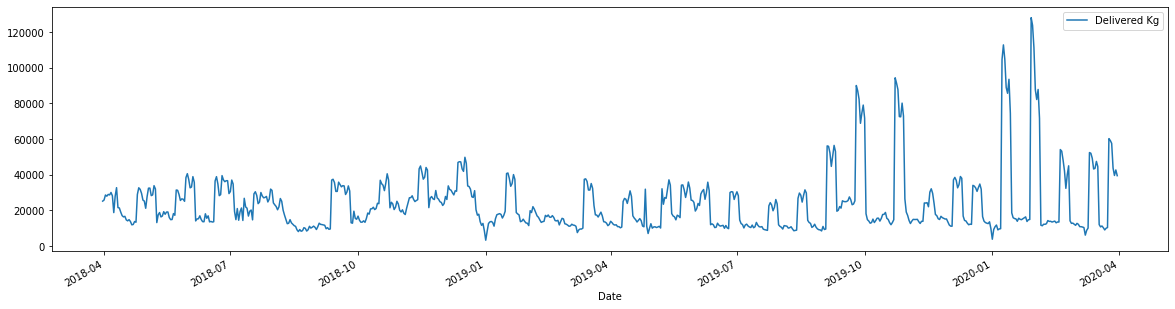

In [27]:
tmp = df[(df['Chain']=='MAGNIT')&(df['PRODUCT_CODE']=='0166')]
tmp['Date'] = pd.to_datetime(tmp['Date'], format='%d.%m.%Y')
tmp.plot(x='Date', figsize=(20, 5))

In [22]:
tmp.sort_values(by='Date')

PRODUCT_CODE   Chain        Date  Delivered Kg
79088         0229  MAGNIT  01.01.2019       2273.92
79089         0229  MAGNIT  01.01.2020       2177.02
79090         0229  MAGNIT  01.02.2019       5410.93
79091         0229  MAGNIT  01.02.2020       6711.60
79092         0229  MAGNIT  01.03.2019       8613.22
...            ...     ...         ...           ...
79815         0229  MAGNIT  31.08.2019      12024.27
79816         0229  MAGNIT  31.10.2018      29398.78
79817         0229  MAGNIT  31.10.2019      13136.58
79818         0229  MAGNIT  31.12.2018       5025.54
79819         0229  MAGNIT  31.12.2019       4820.01

[732 rows x 4 columns]